<a href="https://colab.research.google.com/github/hsimonfroy/diffusion-field-level/blob/main/tests/TSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling using the TSM objective


In [1]:
# !pip install --q diffrax
import jax
from jax import numpy as jnp, random as jr, jit, grad, vmap, tree, value_and_grad, jvp, debug
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline
%load_ext autoreload
%autoreload 2

2025-10-03 08:29:13.093518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1 Stochastic path to sample
$\newcommand{\cA}{\mathcal{A}}\newcommand{\cB}{\mathcal{B}}\newcommand{\cC}{\mathcal{C}}\newcommand{\cF}{\mathcal{F}}\newcommand{\cG}{\mathcal{G}}\newcommand{\cH}{\mathcal{H}}\newcommand{\cL}{\mathcal{L}}\newcommand{\cM}{\mathcal{M}}\newcommand{\cN}{\mathcal{N}}\newcommand{\cO}{\mathcal{O}}\newcommand{\cP}{\mathcal{P}}\newcommand{\cR}{\mathcal{R}}\newcommand{\cS}{\mathcal{S}}\newcommand{\cT}{\mathcal{T}}\newcommand{\cU}{\mathcal{U}}\newcommand{\cW}{\mathcal{W}}\newcommand{\cX}{\mathcal{X}}\newcommand{\cY}{\mathcal{Y}}\newcommand{\cZ}{\mathcal{Z}}\newcommand{\NN}{\mathbb{N}}\newcommand{\ZZ}{\mathbb{Z}}\newcommand{\QQ}{\mathbb{Q}}\newcommand{\RR}{\mathbb{R}}\newcommand{\CC}{\mathbb{C}}\newcommand{\KK}{\mathbb{K}}\newcommand{\SS}{\mathbb{S}}\newcommand{\eps}{\varepsilon}\newcommand{\ph}{\varphi}\newcommand{\pp}{\mathrm{p}}\newcommand{\qq}{\mathrm{q}}\newcommand{\HH}{\mathrm{H}}\newcommand{\PP}{\mathbb{P}}\newcommand{\EE}{\mathbb{E}}\newcommand{\OO}{\mathbb{O}}\newcommand{\Var}{\operatorname{\mathbb{V}\!ar}}\newcommand{\Cov}{\operatorname{\mathbb{C}\!ov}}\newcommand{\bs}{\boldsymbol}\newcommand{\dd}{\mathrm{d}}\newcommand{\dxdy}[2]{\frac{\dd #1}{\dd #2}}\newcommand{\pxpy}[2]{\frac{\partial #1}{\partial #2}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\newcommand{\norm}[1]{\left\lVert#1\right\rVert}\newcommand{\T}{^\top}\newcommand{\ind}{\perp\!\!\!\perp}\newcommand{\1}{\mathbb{1}}\newcommand{\intint}[1]{\left[\!\left[#1\right]\!\right]}\newcommand{\lat}{x}\newcommand{\Lat}{X}\newcommand{\Ls}{\mathcal X}\newcommand{\obs}{y}\newcommand{\Obs}{Y}\newcommand{\Os}{\mathcal Y}\newcommand{\obst}{z}\newcommand{\Obst}{Z}\newcommand{\Ost}{\mathcal Z}$
* Let us have a target $x_1 \sim \pp_1$ and a stochastic Gaussian interpolation $$x_t = \alpha_t x_1 + \beta_t \eps,$$ with $\eps \sim \cN(\bs 0, I)$, scaling term $\alpha_t$, noise term $\beta_t$. We typically want $\alpha_0 = \beta_1 = 0$ and $\alpha_1 = \beta_0 = 1$. Then $$x_t \sim \pp_t = \alpha_t^{-1}\pp_1(\alpha_t^{-1} \cdot) * \cN(0, \beta_t^2).$$
* Let us define drift term $f_t(x) := \frac{\dot \alpha_t}{\alpha_t}x$ and diffusion term $g_t^2 := 2( \frac{\dot \alpha_t}{\alpha_t}\beta_t^2 - \beta_t \dot \beta_t ) = - \alpha_t^2 \dot{\left(\frac{\beta_t^2}{\alpha_t^2}\right)}$
* Then, the 3 following processes $(x(t))_{t}$ admits the same marginals $\forall t, x(t) \sim x_t$:
	* ODE $\begin{cases}\exists t_0, x(t_0) \sim x_{t_0}\\ 	\dd x = v_t(x) \dd t \quad\textrm{with}\quad v_t:= f_t+\frac{g_t^2}{2}\nabla\log\pp_t\end{cases}$
	* Backward (noising) SDE $\begin{cases}x(1) \sim x_{1}\\ 	\dd x = \left(v_t-\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd \tilde W = f_t\ \dd t + g_t\ \dd \tilde W \end{cases}$  
	  with $\tilde W$ a backward Wiener process.
	* Forward (denoising) SDE $\begin{cases}x(0) \sim x_{0}\\ 	\dd x = \left(v_t+\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd W = \left(f_t+g_t^2\nabla\log\pp_t\right) \dd t + g_t\ \dd W\end{cases}$    
	  with $W$ a forward Wiener process.

* Noise scheduling:
	* Variance Preserving, $\beta_t^2 = 1-\alpha_t^2$, which implies $f_t(x) = \frac{\dot \alpha_t}{\alpha_t}x = \frac{g_t^2}{2}x$  
	  Typically $g_t^2 = t g_m^2 + (1-t) g_M^2$, then $\alpha_t = \exp((g_m^2(t^2-1) - g_M^2(1-t)^2)/4)$
	* Variance Exploding, $\alpha_t = 1$, which implies $f_t(x) = 0$ and $g_t^2 = -\dot{\beta_t^2} = -2\beta_t \dot \beta_t$  
	  Typically $\beta_t = \beta_m^t \beta_M^{1-t}$, then $g_t^2 = 2\beta^2 \log\left(\frac{\beta_M}{\beta_m}\right)$
	* Optimal Transport, $\alpha_t = t = 1 - \beta_t$, which implies $f_t(x) = \frac{x}{t}$, $g_t^2 = 2\left(\frac{1}{t} - 1\right)$

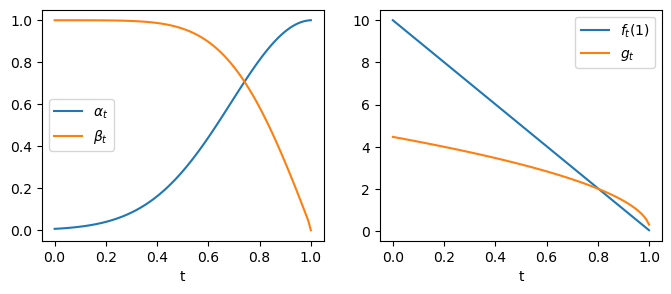

In [49]:
# @title Defining noise scheduling
from fldiffus.stochinterp import StochInterp

stoc = StochInterp(scheduling='VP', dim=2, hutch_div=None)

tlin = jnp.linspace(0,1,100)
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(tlin, stoc.alpha(tlin), label="$\\alpha_t$");
plt.plot(tlin, stoc.beta(tlin), label="$\\beta_t$");
plt.xlabel("t"), plt.legend();

plt.subplot(122)
plt.plot(tlin, vmap(stoc.drift)(tlin, jnp.ones_like(tlin), None), label="$f_t(1)$");
plt.plot(tlin, vmap(stoc.diffusion)(tlin, jnp.ones_like(tlin), None), label="$g_t$");
plt.xlabel("t"), plt.legend();

In [40]:
n_samples = 10000
base_samples = stoc.base.sample(n_samples, jr.key(0))
target_samples = stoc.target.sample(n_samples, jr.key(1))

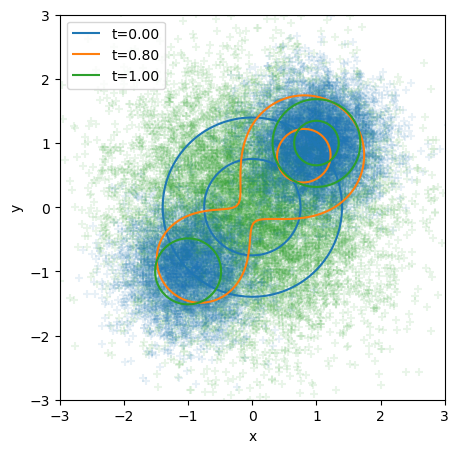

In [41]:
# @title Plot path
if stoc.dim == 1:
    plt.figure(figsize=(12,4.5))
    plt.subplot(1,2,1)
    tlin = jnp.linspace(0, 1, 7)[::-1]
    for t in tlin:
        stoc.plot_prob(stoc.marg(t).log_prob, label=f't={t:.2f}')

    stoc.plot_prob(tfd.Normal(loc=0., scale=1.).log_prob, ':k', label='standard');
    stoc.plot_samples(base_samples, label='base', color=f'C{len(tlin)-1}');
    stoc.plot_samples(target_samples, label='target', color='C0');
    plt.legend()

    plt.subplot(1,2,2)
    stoc.plot_margs()
    
elif stoc.dim == 2:
    plt.figure(figsize=(5,5))
    tlin = [0., 0.8, 1.]
    handles = []
    labels = []

    for it, t in enumerate(tlin):
        quad = stoc.plot_prob(stoc.marg(t).log_prob, levels=2, colors=f'C{it}')
        handles.append(quad.legend_elements()[0][0])
        labels.append(f't={t:.2f}')

    stoc.plot_samples(base_samples, label='base', color=f'C{len(tlin)-1}');
    stoc.plot_samples(target_samples, label='target', color='C0');
    plt.legend(handles, labels);

Let's try to verify that our integration time is going to be good enough, by running backward and forward SDEs, as well as corresponding (forward) ODE. We should obtain base distribution for the former one, and the target distribution for the latter two.

In [42]:
seeds = jr.split(jr.key(0), n_samples)
ts_bsde, xs_bsde = jit(vmap(stoc.backward_sde))(seeds, target_samples)
ts_fsde, xs_fsde = jit(vmap(stoc.forward_sde))(seeds, base_samples)
ts_fode, xs_fode, _ = jit(vmap(stoc.forward_ode))(base_samples)

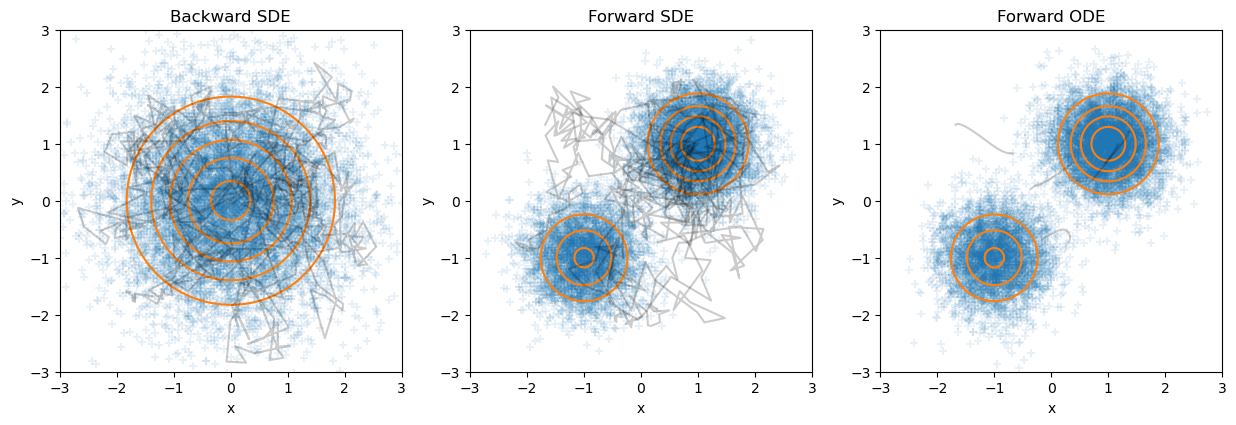

In [43]:
# @title Let's take a look at the trajectories
if stoc.dim == 1:
    plt.figure(figsize=(12,6))
    plt.subplot(231)
    for i in range(100):
        plt.plot(ts_bsde[i], xs_bsde[i], 'k', alpha=0.1);
    plt.ylim(stoc.xlim), plt.xlim(1.,0.)
    plt.title('Backward SDE')

    plt.subplot(232)
    for i in range(100):
        plt.plot(ts_fsde[i], xs_fsde[i], 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward SDE')

    plt.subplot(233)
    for i in range(100):
        plt.plot(ts_fode[i], xs_fode[i], 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward ODE')

    plt.subplot(234)
    stoc.plot_prob(stoc.base.log_prob)
    stoc.plot_samples(xs_bsde[:,-1])

    plt.subplot(235)
    stoc.plot_prob(stoc.target.log_prob)
    stoc.plot_samples(xs_fsde[:,-1])

    plt.subplot(236)
    stoc.plot_prob(stoc.target.log_prob)
    stoc.plot_samples(xs_fode[:,-1])

elif stoc.dim == 2:
    n_traj = 5
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    stoc.plot_prob(stoc.base.log_prob, levels=5, colors='C1')
    stoc.plot_samples(xs_bsde[:,-1], color='C0')

    plt.plot(*xs_bsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Backward SDE')

    plt.subplot(132)
    stoc.plot_prob(stoc.target.log_prob, levels=5, colors='C1')
    stoc.plot_samples(xs_fsde[:,-1], color='C0')

    plt.plot(*xs_fsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward SDE')

    plt.subplot(133)
    stoc.plot_prob(stoc.target.log_prob, levels=5, colors='C1')
    stoc.plot_samples(xs_fode[:,-1], color='C0')

    plt.plot(*xs_fode[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward ODE');

In [50]:
seeds = jr.split(jr.key(0), n_samples)
ts_bsde, xs_bsde = jit(vmap(stoc.backward_sde))(seeds, target_samples)
ts_fsde, xs_fsde = jit(vmap(partial(stoc.forward_sde, params=stoc.params)))(seeds, base_samples)
ts_fode, xs_fode, _ = jit(vmap(partial(stoc.forward_ode, params=stoc.params)))(base_samples)

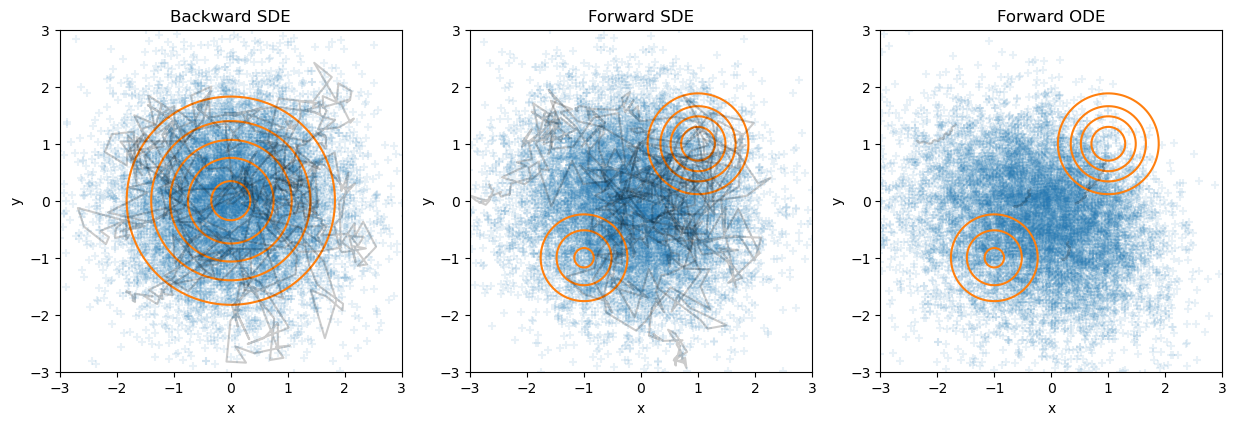

In [51]:
# @title Let's take a look at the trajectories
if stoc.dim == 1:
    plt.figure(figsize=(12,6))
    plt.subplot(231)
    for i in range(100):
        plt.plot(ts_bsde[i], xs_bsde[i], 'k', alpha=0.1);
    plt.ylim(stoc.xlim), plt.xlim(1.,0.)
    plt.title('Backward SDE')

    plt.subplot(232)
    for i in range(100):
        plt.plot(ts_fsde[i], xs_fsde[i], 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward SDE')

    plt.subplot(233)
    for i in range(100):
        plt.plot(ts_fode[i], xs_fode[i], 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward ODE')

    plt.subplot(234)
    stoc.plot_prob(stoc.base.log_prob)
    stoc.plot_samples(xs_bsde[:,-1])

    plt.subplot(235)
    stoc.plot_prob(stoc.target.log_prob)
    stoc.plot_samples(xs_fsde[:,-1])

    plt.subplot(236)
    stoc.plot_prob(stoc.target.log_prob)
    stoc.plot_samples(xs_fode[:,-1])

elif stoc.dim == 2:
    n_traj = 5
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    stoc.plot_prob(stoc.base.log_prob, levels=5, colors='C1')
    stoc.plot_samples(xs_bsde[:,-1], color='C0')

    plt.plot(*xs_bsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Backward SDE')

    plt.subplot(132)
    stoc.plot_prob(stoc.target.log_prob, levels=5, colors='C1')
    stoc.plot_samples(xs_fsde[:,-1], color='C0')

    plt.plot(*xs_fsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward SDE')

    plt.subplot(133)
    stoc.plot_prob(stoc.target.log_prob, levels=5, colors='C1')
    stoc.plot_samples(xs_fode[:,-1], color='C0')

    plt.plot(*xs_fode[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward ODE');

## 2 Score network and associated proposal probability
* Lagrangian formulation: the continuous change of variable formula along a particle trajectory yields $\dd \log \pp_t(x(t)) = - \nabla \cdot v_t(x(t)) \ \dd t$, i.e.$$\log \pp_\tau(x(\tau)) = \log \pp_0(x(0)) - \int^\tau_0 \nabla \cdot v_t(x(t))\dd t = \log \pp_0(x(0)) + \int_\tau^0 \nabla \cdot v_t(x(t))\dd t$$For the ODE flow, we can integrate forward the probability flow starting at $x(0)$, while for the SDE flow we must integrate it backward since we do not know $x(0)$.
* Eulerian formulation: the continuity equation yields $\partial_t \pp_t = -\nabla \cdot (\pp_t v_t)$, i.e. $$\partial_t \log \pp_t = -\nabla \cdot v_t - \nabla \log \pp_t \cdot v_t$$

In [36]:
# @title Define a score model
import flax.linen as nn




class ScoreNN(nn.Module):
    truc:int
    @nn.compact
    def __call__(self, t, x):
        # Encoding time
        freqs = jnp.pi * jnp.arange(1,100,10)
        t *= freqs
        t = jnp.concatenate([jnp.sin(t), jnp.cos(t)],axis=-1)
        # Building network
        h = 32
        act_fn = nn.silu
        xin = x
        x = jnp.concatenate([t, x])
        x = nn.Dense(features=h)(x)
        x = act_fn(x)
        x = nn.Dense(features=h)(x)
        x = act_fn(x)
        x = nn.Dense(features=h)(x)
        x = act_fn(x)
        x = nn.Dense(features=stoc.dim)(x)
        return x - xin + self.truc
    

scorenn = ScoreNN(2)
params = scorenn.init(jr.key(0), jnp.zeros(1), jnp.zeros(stoc.dim))

class UsesModule(nn.Module):
  submodule: nn.Module
  @nn.compact
  def __call__(self, t, x):
    return self.submodule(t, x)


class FlowNN(ScoreNN):
    @nn.compact
    def __call__(self, t, x):
        # mod = ScoreNN(2)
        # x = mod(t, x)
        # return x + 1
        return -1 + ScoreNN.__call__(self, t, x)

# flownn = scorenn.copy()
# flownn.__call__ = flownn

flownn = FlowNN(2)
scorenn.apply(params, 0.5, jnp.zeros(stoc.dim)), 
print(params, '\n\n\n')
# params = flownn.init(jr.key(0), jnp.zeros(1), jnp.zeros(stoc.dim))
print(params, '\n\n\n')
flownn.apply(params, 0.5, jnp.zeros(stoc.dim))



# flownn = FlowNN()
# params = flownn.init(jr.key(0), jnp.zeros(1), jnp.zeros(d))
# params = tree.map(lambda x: jnp.zeros_like(x), params)

{'params': {'Dense_0': {'kernel': Array([[ 6.97693452e-02, -2.58217007e-01,  6.40437230e-02,
         4.50809807e-01,  1.78835154e-01,  8.35599601e-02,
        -7.64935762e-02,  3.03361174e-02, -8.71398896e-02,
        -2.06334263e-01, -6.01544566e-02,  4.65711951e-02,
         5.76975197e-02,  4.81257707e-01,  8.05997625e-02,
        -3.64221297e-02, -3.20966076e-03, -3.04445364e-02,
        -1.60221472e-01,  2.57020086e-01,  1.30973369e-01,
        -4.50751297e-02, -2.55844861e-01,  1.90296564e-02,
        -1.44134648e-02, -4.56338413e-02, -2.13725828e-02,
         1.75462827e-01,  2.14941707e-02,  2.08389863e-01,
         2.89964646e-01,  4.13259305e-03],
       [-8.71575773e-02,  1.09167837e-01,  1.68709069e-01,
         2.89478064e-01, -6.29143715e-02, -1.02580883e-01,
        -1.50221661e-01, -2.19738722e-01,  9.93793383e-02,
         1.97674967e-02, -3.14982831e-01,  1.62939221e-01,
         2.69639075e-01, -2.07257252e-02,  3.19757491e-01,
         7.68029317e-02, -2.40177110e-

Array([0.8808855 , 0.90288603], dtype=float32)

ts.shape: (10000, 100), xs.shape: (10000, 100, 2)


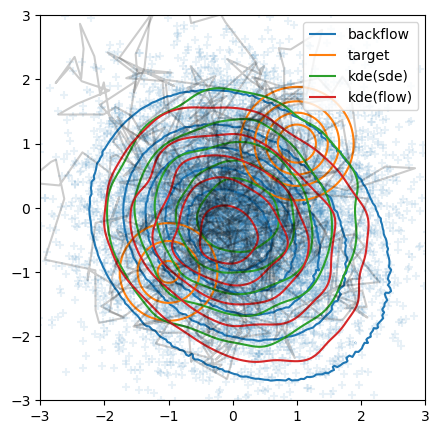

In [54]:
# Let's plot the untrained process
from scipy.stats import gaussian_kde

def plot_result(params, n_samples=10000):
    ts, xs = sample_sde(params, jr.split(jr.key(0), n_samples))
    x1, logp1f = sample_and_logp_ode(params, jr.split(jr.key(1), n_samples))
    print(f"ts.shape: {ts.shape}, xs.shape: {xs.shape}")

    if d == 1:
        logp1s = logp_backflow(params, xlin)
        logp1 = target.log_prob(xlin)
        logp0 = base.log_prob(xlin)

        kde = gaussian_kde(xs[:,-1].T)
        kde_sde = kde(xlin.T)

        kde2 = gaussian_kde(x1.T)
        kde_flow = kde2(xlin.T)

        plt.figure(figsize=(9,3.5))
        plt.subplot(121)
        for i in range(100):
            plt.plot(ts[i], xs[i], 'k', alpha=0.1);

        plt.subplot(122)
        labels = ["backflow", "target", "base", "kde(sde)", "kde(flow)"]
        zzs = [jnp.exp(logp1s), jnp.exp(logp1), jnp.exp(logp0), kde_sde, kde_flow]

        plt.hist(xs[:,-1,0], 100, range=xlim, density=True, alpha=0.5, label="sde");
        for i, zz in enumerate(zzs):
            plt.plot(xlin, zz, label=labels[i], color=f'C{i}');
        plt.legend();
    elif d == 2:
        logp1s = logp_backflow(params, xy).reshape(xx.shape)
        logp1 = target.log_prob(xy).reshape(xx.shape)

        kde = gaussian_kde(xs[:,-1].T)
        kde_sde = kde(xy.T).reshape(xx.shape)

        kde2 = gaussian_kde(x1.T)
        kde_flow = kde2(xy.T).reshape(xx.shape)

        plt.figure(figsize=(5,5))
        handles = []
        labels = ["backflow", "target", "kde(sde)", "kde(flow)"]
        zzs = [jnp.exp(logp1s)+0.01, jnp.exp(logp1), kde_sde, kde_flow]

        for i, zz in enumerate(zzs):
            quad = plt.contour(xx, yy, zz, alpha=1., levels=5, colors=f'C{i}')
            handles.append(quad.legend_elements()[0][0])
        plt.legend(handles, labels)

        plt.scatter(*xs[:,-1].T, marker='+', alpha=0.1, color='C0');
        for i in range(10):
            plt.plot(*xs[i].T, 'k', alpha=0.2);
        
        plt.xlim(xlim), plt.ylim(xlim)
        plt.gca().set_aspect(1.)

plot_result(params, 10000)

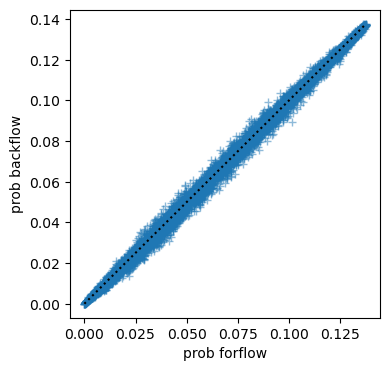

In [55]:
x1, logp1f = sample_and_logp_ode(params, jr.split(jr.key(1), n_samples))
logp1s = logp_backflow(params, x1)

# ts, xs = sample_sde(params, jr.split(jr.key(0), n_samples))
# x1 = xs[:,-1]
# logp1s = logp_sde(params, x1)

asort = logp1f.argsort()
plt.figure(figsize=(4,4))
# plt.plot(logp1f[asort], logp1s[asort], '+', alpha=0.5); 
val1, val2 = jnp.exp(logp1f[asort]), jnp.exp(logp1s[asort])
plt.plot(val1, val2, '+', alpha=0.5);
minmax = [min(val1.min(), val2.min()), max(val1.max(), val2.max())]
# plt.xlim(minmax), plt.ylim(minmax)
plt.plot(minmax, minmax, ':k')
plt.xlabel('prob forflow'), plt.ylabel('prob backflow');

## 3 Loss and training
* Most of the approches rely on estimating $v_t$ or $\nabla\log \pp_t$ via the identities:
	* $v_t(x_t) = \int v_{t \mid 1}(x_t \mid x_1)\ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{t\mid 1}(x_t \mid x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{1}(x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$    for additive noise
* Let us define the following losses:
	* $\cL_\mathrm{FM}(\theta) := \EE_{t, x_t}[\norm{v_t^{\theta}(x_t) - v_t(x_t)}^2]$
	* $\cL_\mathrm{DFM}(\theta) := \EE_{t, x_t, x_1}[\norm{v_t^{\theta}(x_t) - v_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TFM}(\theta) := \EE_{t, x_t, x_1}[\norm{v_t^{\theta}(x_t) - \alpha_t^{-1} v_{1}(x_1)}^2]$==?????==
	* $\cL_\mathrm{SM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t}(x_t)}^2]$
	* $\cL_\mathrm{ISM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) }^2 + 2\nabla \cdot s^{\theta}_t(x_t) ]$
	* $\cL_\mathrm{DSM}(\theta) := \EE_{t, x_t, x_1}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TSM}(\theta) := \EE_{t, x_t, x_1}[\norm{s^{\theta}_t(x_t) - \alpha_t^{-1} \nabla\log \pp_{t}(x_t)}^2]$    for additive noise [*source*](http://arxiv.org/abs/2402.08667)
	* $\cL_\mathrm{EM}(\theta) := \EE_{t, x_t, x_1}[\norm{u^{\theta}_t(x_t) +\log \pp_{1}(x_1)}^2]$    [*source*](https://arxiv.org/pdf/2409.09787)
* Then we have
	* $\nabla_\theta \cL_\mathrm{FM} = \nabla_\theta \cL_\mathrm{DFM}$ and their argmin on $v^\theta$ is $v$.
	* $\nabla_\theta \cL_\mathrm{SM}= \nabla_\theta \cL_\mathrm{ISM} = \nabla_\theta \cL_\mathrm{DSM} = \nabla_\theta \cL_\mathrm{TSM}$ and their argmin on $s^\theta$ is $\nabla\log \pp$.

* Two ways, with $s_t(y_1,y_t) = \lambda_t \nabla\log\pp_1(x_1) + (1-\lambda_t)\nabla\log \pp_{t\mid 1}(y_t \mid y_1)$ (mixture DSM+TSM)
	* IS in loss$$\cL(\theta) := \EE_{t, y_1, y_t}[w(y_1) \norm{s^{\theta}_t(y_t) - s_t(y_1,y_t)}^2]$$
	* IS in target
$$\cL(\theta) := \EE_{t, y_1, y_t}[\norm{s^{\theta}_t(y_t) - \EE_{z_1\mid y_t}[w(z_1)s_t(z_1,z_t)]}^2]$$



In [ ]:
def loss_sm(params, t, x1, z, score1, imp_weight):
    alphat = alpha(t)[:,None] # (batch_size, 1)
    betat = beta(t)[:,None] # (batch_size, 1)
    # gt = vmap(diffusion)(t, jnp.ones_like(t)[:,None], None)

    xt = alphat * x1 + betat * z
    score_est = vmap(partial(scorenn.apply, params))(t, xt)

    ##### Denoising Score Matching #####
    ## Default time weighting
    # error_dsm = (score_est + z / betat)**2
    ## Minimum variance time weighting, see http://arxiv.org/abs/2101.09258
    error_dsm = (score_est * betat + z)**2
    ## Maximum likelihood time weighting, see http://arxiv.org/abs/2101.09258
    # error_dsm = ((score_est + z / betat) * gt)**2

    ##### Target Score Matching #####
    ## Default time weighting
    # error_tsm = (score_est - score1 / alphat)**2
    ## Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
    error_tsm = (score_est * alphat - score1)**2

    # return ((error_dsm) * imp_weight).mean()
    # return ((error_tsm) * imp_weight).mean()
    return ((error_dsm + error_tsm) * imp_weight).mean()


# Training loop
batch_size = 2**14
seed = jr.key(0)
losses = []
eval_per_esss = []
params = scorenn.init(jr.key(1), jnp.zeros(1), jnp.zeros(d))
off_policy = True


# Define the optimizer
import optax
optimizer = optax.chain(
    optax.adam(
        learning_rate=1e-2
        ),
    optax.contrib.reduce_on_plateau(
        factor=0.5,
        patience=10,
        ),
    )
opt_state = optimizer.init(params)

# Define the training step
@jit
def train_step(params, opt_state, seed):
    # Sample true x1 or proposal x1
    seed_samp, seed_time, seed_noise = jr.split(seed, 3)
    if off_policy:
        # # Sample from proposal and compute importance weights
        # ts, xs = sample_sde(params, jr.split(seed_samp, batch_size))
        # x1 = xs[:,-1] # (batch_size, dim)
        # logprop = logp_sde(params, x1)

        x1 = base.sample(batch_size, seed_samp) # DEBUG
        logprop = vmap(base.log_prob)(x1)
        
        logp1, score1 = vmap(value_and_grad(target.log_prob))(x1)
        imp_weight = logp1 - logprop # (batch_size,)
        
        # q01, q99 = jnp.quantile(imp_weight, jnp.array([0.01, 0.99]))
        # debug.print("\nweights: q01 {q01}, q99 {q99}", q01=q01, q99=q99)
        
        imp_weight = jnp.clip(imp_weight, a_max=jnp.quantile(imp_weight, 0.99)) # Clip too large weights
        # imp_weight = jnp.clip(imp_weight, max=q99)
        imp_weight = jnp.exp(imp_weight - imp_weight.max())
        imp_weight = (imp_weight / imp_weight.mean())[:,None] # (batch_size, 1)
    else:
        # Sample from target directly
        x1 = target.sample(batch_size, seed_samp) # (batch_size, dim)
        score1 = vmap(grad(target.log_prob))(x1)
        imp_weight = jnp.ones((batch_size, 1))

    # For importance weights such that E[W]=1, we have n/ESS = E[W^2] = Var[W] + 1
    # eval_per_ess = (imp_weight**2).mean()
    eval_per_ess = ((imp_weight / imp_weight.mean())**2).mean()

    # Sample t and xt
    t = jr.uniform(seed_time, (batch_size,), minval=eps, maxval=1-eps)
    # t = jr.uniform(seed_time, (batch_size,), minval=1e-6, maxval=1-1e-6)
    z = jr.normal(seed_noise, jnp.shape(x1))

    loss, grads = value_and_grad(loss_sm)(params, t, x1, z, score1, imp_weight)
    updates, opt_state = optimizer.update(grads, opt_state, params, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, (loss, eval_per_ess)

In [ ]:
from jax.scipy.special import logsumexp
def loss_si(params, t, x1, z, seed_si):
    alphat = alpha(t)[:,None] # (batch_size, 1)
    betat = beta(t)[:,None] # (batch_size, 1)
    xt = alphat * x1 + betat * z
    score_est = vmap(partial(scorenn.apply, params))(t, xt)

    # imp_size = 1000
    # z1prop = jr.normal(seed_si, (imp_size,)+xt.shape)
    # x1prop = z1prop * betat + xt # (imp_size, batch_size, dim)

    # ##### Denoising Score Identity #####
    # # imp_weight = vmap(lambda x: target.log_prob(x / alphat))(x1prop) # (imp_size, batch_size)
    # imp_weight = vmap(vmap(lambda x, alpha: target.log_prob(x / alpha)))(x1prop, jnp.broadcast_to(alphat, x1prop.shape)) # (imp_size, batch_size)
    # imp_weight = jnp.exp(imp_weight - imp_weight.max(0)) # (imp_size, batch_size)
    # imp_weight = (imp_weight / imp_weight.mean(0))[...,None] # (imp_size, batch_size, 1)
    # # # Default time weighting
    # # score_dsi = (-z1prop / betat * imp_weight).mean(0)
    # ## Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
    # print(z1prop.shape, betat.shape, imp_weight.shape)
    # score_dsi = (-z1prop * betat * imp_weight).mean(0)

    # ##### Target Score Identity #####
    # # lse = lambda x: logsumexp(vmap(lambda xx: target.log_prob(xx / alphat))(x), axis=0)
    # lse = lambda x: logsumexp(vmap(vmap(lambda xx, alpha: target.log_prob(xx / alpha)))(x, jnp.broadcast_to(alphat, x.shape)), axis=0)
    # # lse = lambda x: logsumexp(vmap(vmap(target.log_prob(x / alphat))), axis=0)
    # # # Default time weighting
    # # score_tsi = grad(lse)(x1prop) / alphat
    # # Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
    # score_tsi = vmap(grad(lse))(x1prop) * alphat


    def score_dsi(seed, xt, alphat, betat):
        imp_size = 10000
        z1prop = jr.normal(seed, (imp_size, xt.shape[-1]))
        x1prop = z1prop * betat + xt # (imp_size, dim)

        ##### Denoising Score Identity #####
        imp_weight = vmap(lambda x: target.log_prob(x / alphat))(x1prop) # (imp_size,)
        imp_weight = jnp.exp(imp_weight - imp_weight.max(0))
        imp_weight = (imp_weight / imp_weight.mean(0))[...,None] # (imp_size, 1)
        # # Default time weighting
        score_dsi = (-z1prop / betat * imp_weight).mean(0)
        ## Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
        # score_dsi = (-z1prop * betat * imp_weight).mean(0)

        ##### Target Score Identity #####
        lse = lambda x: logsumexp(vmap(lambda zz: target.log_prob((zz * betat + x) / alphat))(z1prop), axis=0)
        # # Default time weighting
        score_tsi = grad(lse)(xt) / alphat
        # Equivalent to score_tsi = (vmap(grad(lambda x: target.log_prob(x / alphat)))(x1prop) * imp_weight).mean(0) / alphat
        # Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
        # score_tsi = grad(lse)(xt) * alphat

        # score_si = score_dsi + score_tsi
        score_si = score_dsi
        return score_si
    
    score_si = vmap(score_dsi)(jr.split(seed_si, x1.shape[0]), xt, alphat, betat)
    return ((score_est - score_si)**2).mean()


# Training loop
batch_size = 2**14
seed = jr.key(0)
losses = []
eval_per_esss = []
params = scorenn.init(jr.key(1), jnp.zeros(1), jnp.zeros(d))
off_policy = False

# Define the optimizer
import optax
optimizer = optax.chain(
    optax.adam(
        learning_rate=1e-3
        ),
    optax.contrib.reduce_on_plateau(
        factor=0.5,
        patience=10,
        ),
    )
opt_state = optimizer.init(params)

# Define the training step
@jit
def train_step(params, opt_state, seed):
    # Sample true x1 or proposal x1
    seed_samp, seed_time, seed_noise, seed_si = jr.split(seed, 4)
    if off_policy:
        # Sample from proposal and compute importance weights
        ts, xs = sample_sde(params, jr.split(seed_samp, batch_size))
        x1 = xs[:,-1] # (batch_size, dim)
    else:
        # Sample from target directly
        x1 = target.sample(batch_size, seed_samp) # (batch_size, dim)

    # Sample t and xt
    t = jr.uniform(seed_time, (batch_size,), minval=eps, maxval=1-eps)
    # t = jr.uniform(seed_time, (batch_size,), minval=1e-6, maxval=1-1e-6)
    z = jr.normal(seed_noise, jnp.shape(x1))

    loss, grads = value_and_grad(loss_si)(params, t, x1, z, seed_si)
    updates, opt_state = optimizer.update(grads, opt_state, params, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, (loss, 1.)


weights: q01 -10.438755989074707, q99 2.037215232849121
Epoch 0, Loss: 3.92617, n/ESS: 3.64122, lr scale: 1.0

weights: q01 -11.27729606628418, q99 2.0423877239227295

weights: q01 -10.827863693237305, q99 2.0156264305114746

weights: q01 -10.455474853515625, q99 2.040578842163086

weights: q01 -10.411354064941406, q99 2.0593643188476562

weights: q01 -10.547225952148438, q99 2.053861618041992

weights: q01 -10.851839065551758, q99 2.029538631439209

weights: q01 -10.642398834228516, q99 2.031700611114502

weights: q01 -10.813180923461914, q99 2.0462019443511963

weights: q01 -10.592531204223633, q99 2.0036873817443848

weights: q01 -11.07072925567627, q99 2.041738510131836
Epoch 10, Loss: 3.90622, n/ESS: 3.65699, lr scale: 1.0

weights: q01 -10.784515380859375, q99 2.020385503768921

weights: q01 -10.880075454711914, q99 2.0393121242523193

weights: q01 -10.418734550476074, q99 2.0134968757629395

weights: q01 -10.91589069366455, q99 2.037698984146118

weights: q01 -10.62751102447509

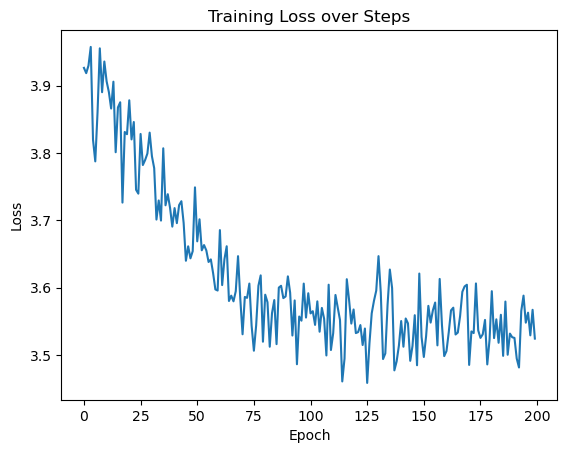

In [57]:
for epoch in range(200):
    seed, seed_train = jr.split(seed, 2)
    params, opt_state, (loss, eval_per_ess) = train_step(params, opt_state, seed)
    losses.append(loss)
    eval_per_esss.append(eval_per_ess)

    if epoch % 10 == 0:
        # print(f"Epoch {epoch}, Loss: {loss}, lr scale: {optax.tree.get(optim_state, 'scale')}")
        print(f"Epoch {epoch}, Loss: {loss:.5f}, n/ESS: {eval_per_ess:.5f}, lr scale: {opt_state[1].scale}")

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

ts.shape: (10000, 100), xs.shape: (10000, 100, 2)


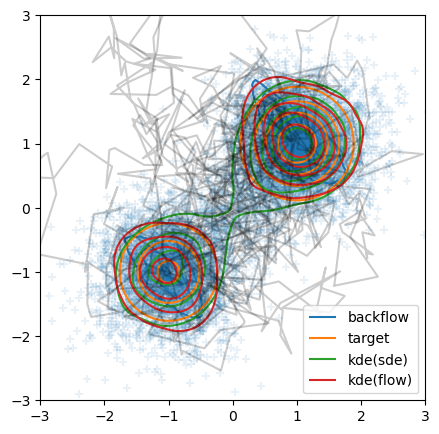

In [58]:
plot_result(params)

In [ ]:

ts, xs = sample_sde(params, jr.split(jr.key(0), n_samples))
# Fit KDE on the final xs samples
kde = gaussian_kde(xs[:, -1].T)

# Evaluate KDE on grid
kde_sde = kde(np.vstack([xx.flatten(), yy.flatten()]))
kde_sde = kde_sde.reshape(xx.shape)

# Plot KDE as contour
plt.figure(figsize=(5,5))
contour = plt.contour(xx, yy, kde_sde, levels=5, colors='C2')
plt.scatter(xs[:, -1, 0], xs[:, -1, 1], alpha=0.1, marker='+', color='C2', label='xs samples')
plt.title('KDE Contour of xs samples')
plt.xlim(xlim)
plt.ylim(xlim)
plt.gca().set_aspect(1.)
plt.legend()
plt.show()

ts.shape: (10000, 100), xs.shape: (10000, 100, 2)


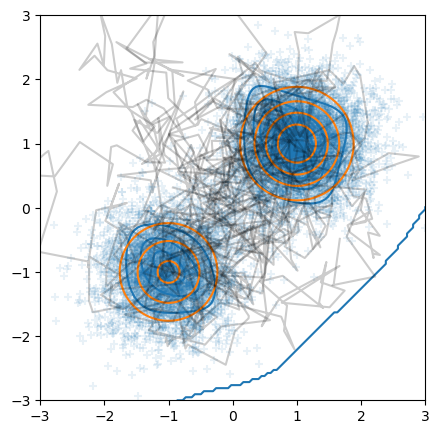

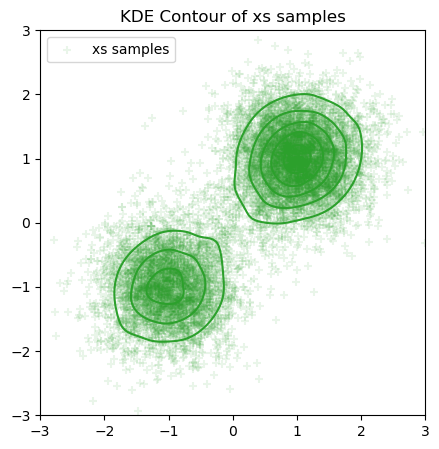

In [ ]:
from scipy.stats import gaussian_kde

plot_result(params)
ts, xs = sample_sde(params, jr.split(jr.key(0), n_samples))
# Fit KDE on the final xs samples
kde = gaussian_kde(xs[:, -1].T)

# Evaluate KDE on grid
kde_sde = kde(np.vstack([xx.flatten(), yy.flatten()]))
kde_sde = kde_sde.reshape(xx.shape)

# Plot KDE as contour
plt.figure(figsize=(5,5))
contour = plt.contour(xx, yy, kde_sde, levels=5, colors='C2')
plt.scatter(xs[:, -1, 0], xs[:, -1, 1], alpha=0.1, marker='+', color='C2', label='xs samples')
plt.title('KDE Contour of xs samples')
plt.xlim(xlim)
plt.ylim(xlim)
plt.gca().set_aspect(1.)
plt.legend()
plt.show()

ts.shape: (10000, 100), xs.shape: (10000, 100, 2)


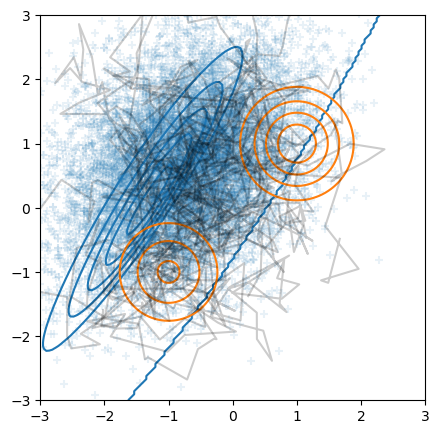

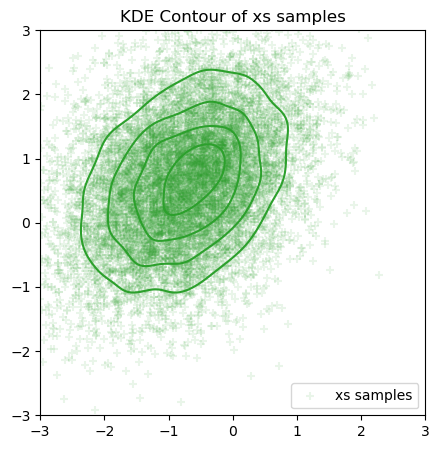

In [ ]:
from scipy.stats import gaussian_kde

plot_result(params)
ts, xs = sample_sde(params, jr.split(jr.key(0), n_samples))
# Fit KDE on the final xs samples
kde = gaussian_kde(xs[:, -1].T)

# Evaluate KDE on grid
kde_sde = kde(np.vstack([xx.flatten(), yy.flatten()]))
kde_sde = kde_sde.reshape(xx.shape)

# Plot KDE as contour
plt.figure(figsize=(5,5))
contour = plt.contour(xx, yy, kde_sde, levels=5, colors='C2')
plt.scatter(xs[:, -1, 0], xs[:, -1, 1], alpha=0.1, marker='+', color='C2', label='xs samples')
plt.title('KDE Contour of xs samples')
plt.xlim(xlim)
plt.ylim(xlim)
plt.gca().set_aspect(1.)
plt.legend()
plt.show()

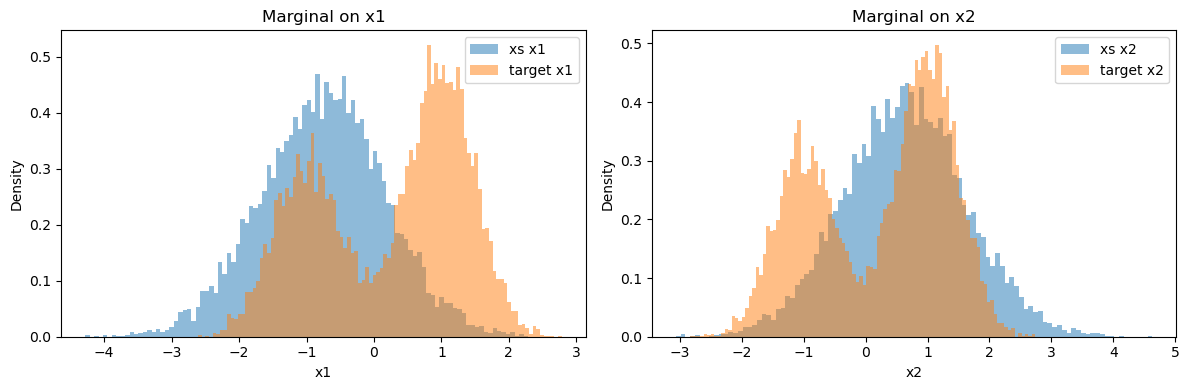

In [ ]:

xs[:,-1]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Marginal on x1
axs[0].hist(xs[:, -1, 0], bins=100, alpha=0.5, label='xs x1', density=True)
axs[0].hist(target.sample(n_samples, seed=jr.key(0))[:, 0], bins=100, alpha=0.5, label='target x1', density=True)
axs[0].set_xlabel('x1')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].set_title('Marginal on x1')

# Marginal on x2
axs[1].hist(xs[:, -1, 1], bins=100, alpha=0.5, label='xs x2', density=True)
axs[1].hist(target.sample(n_samples, seed=jr.key(0))[:, 1], bins=100, alpha=0.5, label='target x2', density=True)
axs[1].set_xlabel('x2')
axs[1].set_ylabel('Density')
axs[1].legend()
axs[1].set_title('Marginal on x2')

plt.tight_layout()
plt.show()

In [14]:
# # scores = jnp.broadcast_to(scores[:,None], (*ts.shape, d)) # (batch_size, traj_length, dim)
# x1s = jnp.broadcast_to(x1s[:,None], (*ts.shape, d)) # (batch_size, traj_length, dim)
# # ws = jnp.broadcast_to(ws[:,None], ts.shape) # (batch_size, traj_length)
# # scores = scores.reshape(-1, d)
# x1s = x1s.reshape(-1, d)
# # ws = ws.reshape(-1)
# ts = ts.reshape(-1)
